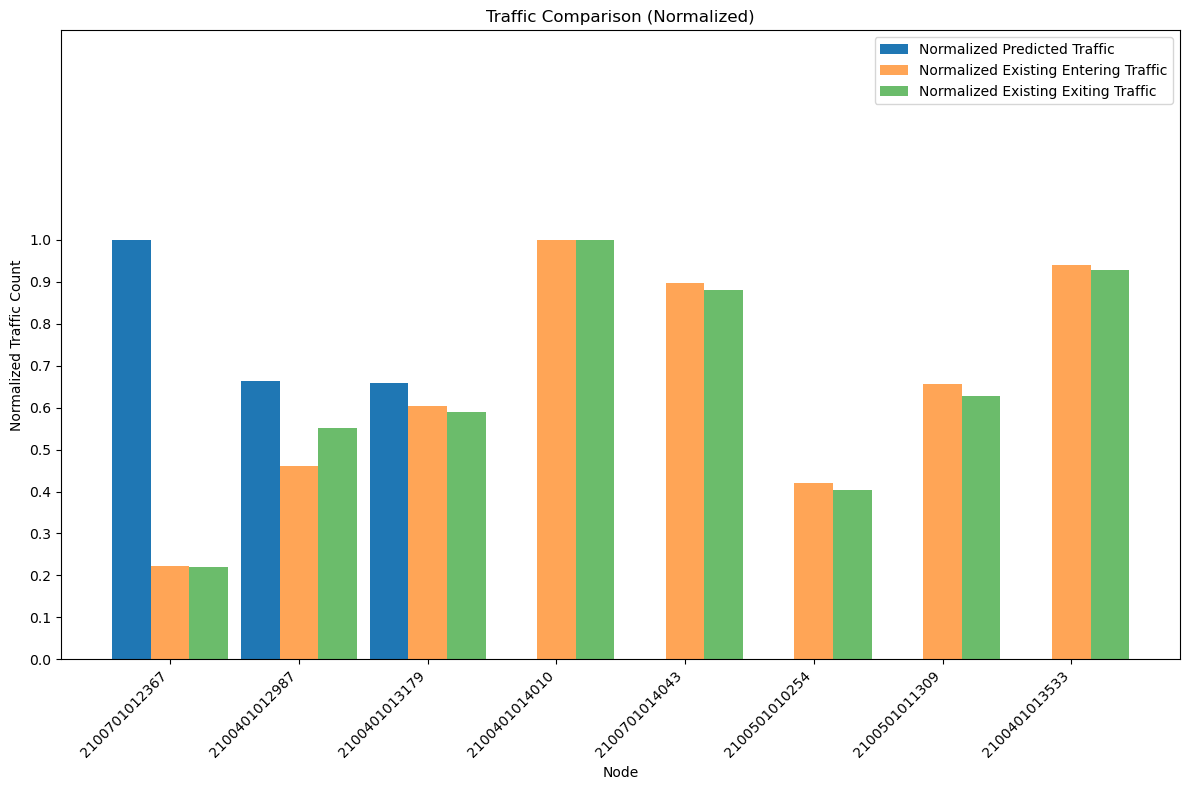

Time taken to generate normalized graph: 0.11 seconds


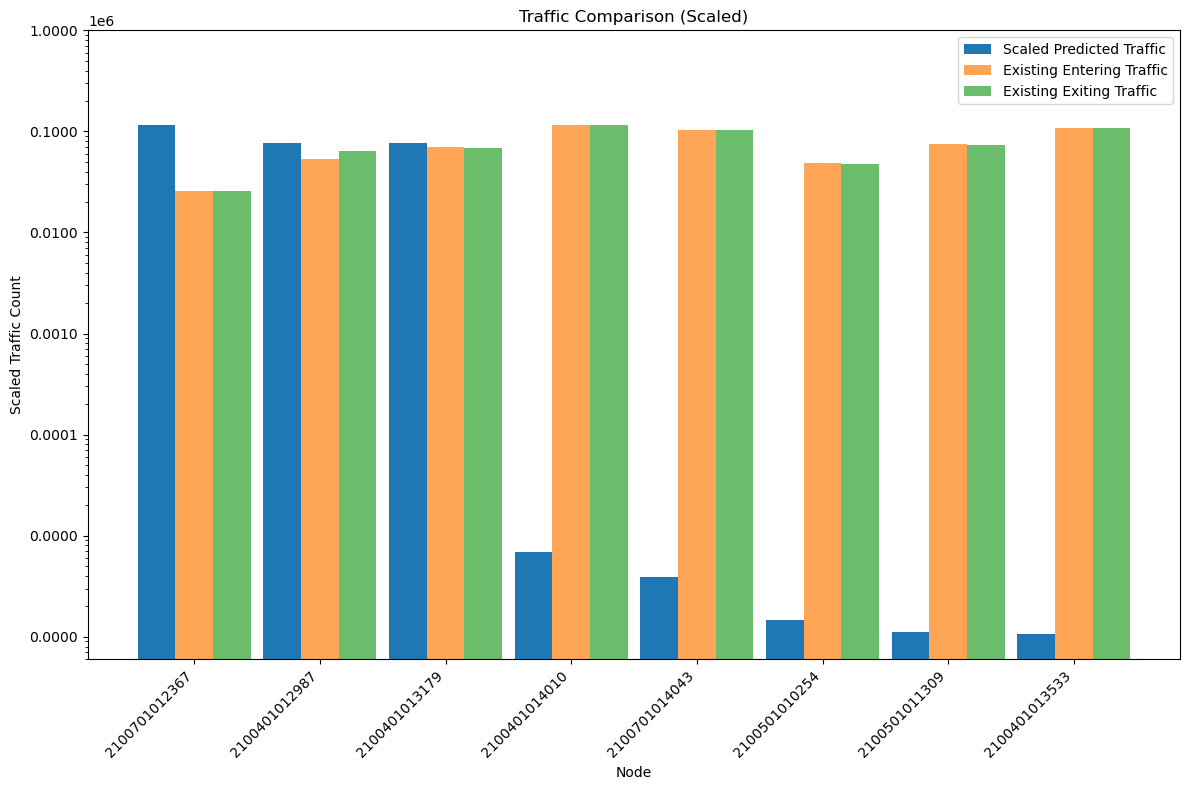

Time taken to generate scaled graph: 0.23 seconds


In [14]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 파일 로드
predicted_df = pd.read_csv('C:/Users/User/predicted_congested_nodes_0423.csv', encoding='utf-8-sig')
entering_df = pd.read_csv('D:/바탕 화면/DSRC/진출진입/entering_0423.csv', encoding='utf-8-sig')

# Node 열을 문자열로 변환
predicted_df['Node'] = predicted_df['Node'].astype(str)
entering_df['Node'] = entering_df['RSE_ID'].astype(str)

# 진입/진출 데이터를 Node별로 그룹화하여 합산
existing_entering_counts = entering_df.groupby('Node')['EnteringCount'].sum().reset_index()
existing_exiting_counts = entering_df.groupby('Node')['ExitingCount'].sum().reset_index()

# 예측 데이터와 실제 데이터 병합
comparison_df = pd.merge(predicted_df, existing_entering_counts, on='Node', how='left')
comparison_df = pd.merge(comparison_df, existing_exiting_counts, on='Node', how='left')
comparison_df.rename(columns={'EnteringCount': 'ExistingEnteringCount', 'ExitingCount': 'ExistingExitingCount'}, inplace=True)

# 결측값 처리
comparison_df.fillna(0, inplace=True)

# 정규화
comparison_df['PredictedCount_normalized'] = comparison_df['PredictedCount'] / comparison_df['PredictedCount'].max()
comparison_df['ExistingEnteringCount_normalized'] = comparison_df['ExistingEnteringCount'] / comparison_df['ExistingEnteringCount'].max()
comparison_df['ExistingExitingCount_normalized'] = comparison_df['ExistingExitingCount'] / comparison_df['ExistingExitingCount'].max()

# 비례 변환
max_existing_count = max(comparison_df['ExistingEnteringCount'].max(), comparison_df['ExistingExitingCount'].max())
comparison_df['PredictedCount_scaled'] = comparison_df['PredictedCount'] * (max_existing_count / comparison_df['PredictedCount'].max())

# 데이터 시각화 함수 정의
def plot_traffic_comparison(df, plot_type="normalized"):
    start_time = time.time()
    x = np.arange(len(df))
    width = 0.3

    fig, ax = plt.subplots(figsize=(12, 8))
    
    if plot_type == "normalized":
        ax.bar(x - width, df['PredictedCount_normalized'], width, label='Normalized Predicted Traffic')
        ax.bar(x, df['ExistingEnteringCount_normalized'], width, alpha=0.7, label='Normalized Existing Entering Traffic')
        ax.bar(x + width, df['ExistingExitingCount_normalized'], width, alpha=0.7, label='Normalized Existing Exiting Traffic')
        ax.set_ylabel('Normalized Traffic Count')
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        y_max = max(df[['PredictedCount_normalized', 'ExistingEnteringCount_normalized', 'ExistingExitingCount_normalized']].max().max(), 1.5 * df['PredictedCount_normalized'].max())
        ax.set_ylim(0, y_max)
    elif plot_type == "scaled":
        ax.bar(x - width, df['PredictedCount_scaled'], width, label='Scaled Predicted Traffic')
        ax.bar(x, df['ExistingEnteringCount'], width, alpha=0.7, label='Existing Entering Traffic')
        ax.bar(x + width, df['ExistingExitingCount'], width, alpha=0.7, label='Existing Exiting Traffic')
        ax.set_ylabel('Scaled Traffic Count')
        ax.set_yscale('log')
        ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
        ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

    ax.set_title(f'Traffic Comparison ({plot_type.capitalize()})')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Node'], rotation=45, ha='right')
    ax.set_xlabel('Node')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to generate {plot_type} graph: {elapsed_time:.2f} seconds")

# 시각화 함수 호출
day_data = comparison_df.head(10)  # 상위 10개 노드만 시각화

# 정규화 비교 그래프
plot_traffic_comparison(day_data, plot_type="normalized")

# 비례 변환 비교 그래프
plot_traffic_comparison(day_data, plot_type="scaled")
